In [ ]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jaxgp.tests import testfunctions, optimizertesting

from jaxgp.utils import Logger
from jaxgp.kernels import RBF

## Initial playing around

In [ ]:
# num_gridpoints = jnp.array([100,100])
# ran = (jnp.array([-5.0,5.0]), jnp.array([-5.0,5.0]))

In [ ]:
# X, Y = optimizertesting.create_training_data_2D(0, num_gridpoints, ran, 0.0, testfunctions.himmelblau)
# Y = Y[:,0]

# means = jnp.load("./prediction_files/himmelblaumeansTNC.npz")
# stds = jnp.load("./prediction_files/himmelblaustdsTNC.npz")

In [ ]:
# cut = -1
# Y_slice = Y.reshape(100,100)
# Y_slice = Y_slice[:,cut]
# mean_slice = means["arr_3"].reshape(100,100)
# mean_slice = mean_slice[:,cut]
# std_slice = stds["arr_3"].reshape(100,100)
# std_slice = std_slice[:,cut]

# x = jnp.linspace(*ran[0], 100)

# plt.plot(x,mean_slice)
# plt.fill_between(x, mean_slice-std_slice, mean_slice+std_slice, alpha=0.5)
# plt.plot(x,Y_slice)

In [ ]:
# plt.pcolormesh(jnp.abs(Y-means["arr_3"]).reshape(100,100))
# plt.colorbar()

In [ ]:
# plt.pcolormesh(Y.reshape(100,100))
# plt.colorbar()

In [ ]:
# plt.pcolormesh(means["arr_3"].reshape(100,100))
# plt.colorbar()

In [ ]:
# plt.pcolormesh(stds["arr_3"].reshape(100,100))
# plt.colorbar()

## Testing

In [ ]:
optimizers = ["L-BFGS-B", "TNC"]#, "SLSQP"]
fun = lambda x: testfunctions.himmelblau(x)/800.0
num_gridpoints = jnp.array([100,100])
ran = (jnp.array([-5.0,5.0]), jnp.array([-5.0,5.0]))

in_dir = "./data_files/different_number_of_datapoints"

noise = 0.1
seed = 0

grid1 = jnp.linspace(*ran[0],100)
grid2 = jnp.linspace(*ran[1],100)
grid = jnp.array(jnp.meshgrid(grid1, grid2)).reshape(2,-1).T

f_vals = [1, 5, 20]
# d_vals = [5, 10, 15, 20, 30, 40, 50]#, 70, 90, 100, 120, 150, 180]
# d_vals = [200, 300, 400, 500, 1000]
d_vals = [5, 20, 50, 100, 200]

kernel = RBF(3)
param_shape = (3,)
param_bounds = (1e-3, 10.0)

iters_per_optimizer = 3

X_train, Y_train = optimizertesting.create_training_data_2D(seed, num_gridpoints, ran, noise, fun)

for num_f_vals in f_vals:
    for num_d_vals in d_vals:
        for optimizer in optimizers:
            print(f"Optimizer {optimizer}")
            logger = Logger(optimizer)

            means, stds = optimizertesting.create_test_data_2D(X_train=X_train, Y_train=Y_train, num_f_vals=num_f_vals, num_d_vals=num_d_vals,
                                                logger=logger, kernel=kernel, param_bounds=param_bounds, param_shape=param_shape, noise=noise, optimizer=optimizer,iters=iters_per_optimizer, evalgrid=grid, seed=seed)
            
            jnp.savez(f"{in_dir}/him_f{num_f_vals}d{num_d_vals}means{optimizer}", *means)
            jnp.savez(f"{in_dir}/him_f{num_f_vals}d{num_d_vals}stds{optimizer}", *stds)
            params = []
            losses = []
            for elem in logger.iters_list:
                params.append(elem[0])
                losses.append(elem[1])
            jnp.savez(f"{in_dir}/him_f{num_f_vals}d{num_d_vals}params{optimizer}", *params)
            jnp.savez(f"{in_dir}/him_f{num_f_vals}d{num_d_vals}losses{optimizer}", *losses)

In [13]:
with open("test.txt",mode="w") as f:
    for num_f_vals in f_vals:
        for num_d_vals in d_vals:
            _, Y = optimizertesting.create_training_data_2D(0, num_gridpoints, ran, 0.0, fun)
            Y = Y[:,0]
            
            f.write("-"*70 + "\n")
            f.write(f"Current vals: {num_d_vals} d_vals, {num_f_vals} f_vals\n")
            
            for optimizer in optimizers:
                means = jnp.load(f"{in_dir}/him_f{num_f_vals}d{num_d_vals}means{optimizer}.npz")
                stds = jnp.load(f"{in_dir}/him_f{num_f_vals}d{num_d_vals}stds{optimizer}.npz")

                f.write(f"optimizer: {optimizer}\n")

                for iter, (mean, std) in enumerate(zip(means.values(), stds.values())):
                    conf68 = jnp.where(jnp.abs(Y-mean) <= std, 0, 1)
                    conf95 = jnp.where(jnp.abs(Y-mean) <= 2*std, 0, 1)

                    mse = jnp.mean((Y-mean)**2)

                    maxdiff = jnp.max(jnp.abs(Y-mean))
                    maxstd = jnp.max(std)

                    f.write(f"iter {iter}: 68% = {jnp.mean(conf68):.5f}, 95% = {jnp.mean(conf95):.5f}, maxerr = {maxdiff:.5f}, mse = {mse:.5f}, maxstd = {maxstd:.5f}\n")

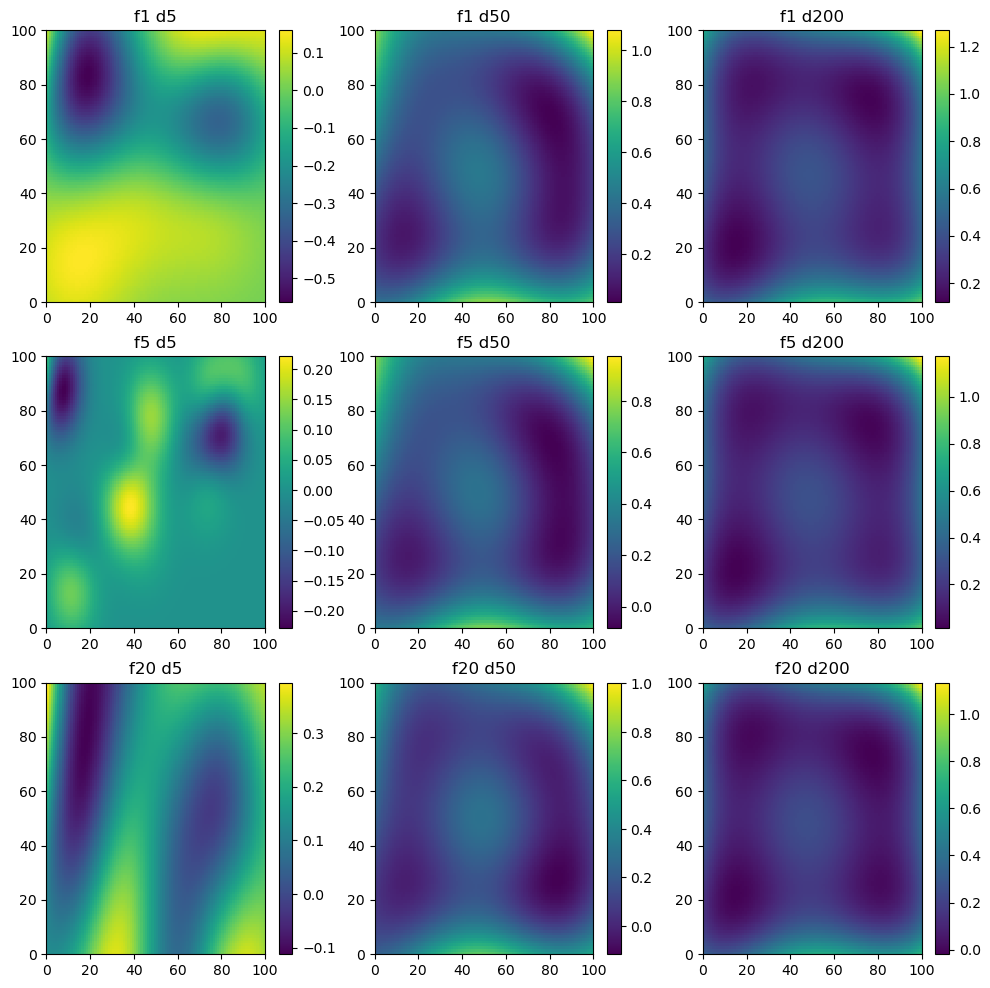

In [18]:
f_vals = [1, 5, 20]
d_vals = [5, 50, 200]
optimizer = "TNC"

fig, ax = plt.subplots(3,3, figsize=(12,12))

for i,num_f_vals in enumerate(f_vals):
    for j,num_d_vals in enumerate(d_vals):
        means = jnp.load(f"{in_dir}/him_f{num_f_vals}d{num_d_vals}means{optimizer}.npz")
        mean = means["arr_0"]
        
        ax[i,j].set_title(f"f{num_f_vals} d{num_d_vals}")
        im = ax[i,j].pcolormesh(mean.reshape(100,100))
        fig.colorbar(im, ax=ax[i,j])

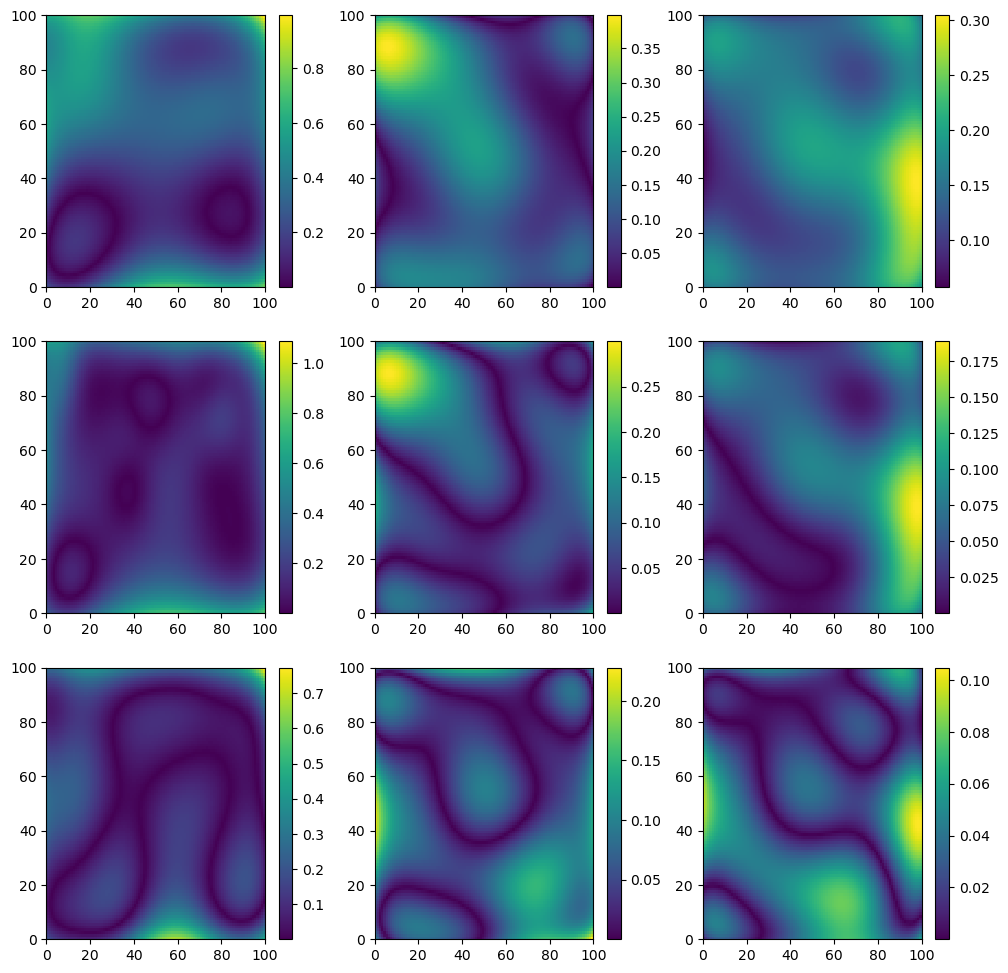

In [19]:
f_vals = [1, 5, 20]
d_vals = [5, 50, 200]
optimizer = "TNC"

_, Y_test = optimizertesting.create_training_data_2D(seed, num_gridpoints, ran, 0.0, fun)
Y_test = Y_test[:,0]

fig, ax = plt.subplots(3,3, figsize=(12,12))

for i,num_f_vals in enumerate(f_vals):
    for j,num_d_vals in enumerate(d_vals):
        means = jnp.load(f"{in_dir}/him_f{num_f_vals}d{num_d_vals}means{optimizer}.npz")
        mean = means["arr_0"]
        
        im = ax[i,j].pcolormesh(jnp.abs(mean-Y_test).reshape(100,100))
        fig.colorbar(im, ax=ax[i,j])